In [1]:
#pre requirements
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.5.0

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!nvidia-smi

Sun Dec 31 13:51:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150         WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P5              N/A / ERR! |    131MiB /  2048MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Load data into tf dataset

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=150

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset3",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12000 files belonging to 12 classes.


### Check information

In [7]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'no_leaf',
 'not_tomato_leaf']

In [8]:
len(dataset)

375

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

#(batch_size, H, V, Channel)

(32, 256, 256, 3)
[[[[165.        152.        159.       ]
   [151.        138.        145.       ]
   [142.        129.        136.       ]
   ...
   [135.        122.        129.       ]
   [178.        165.        172.       ]
   [177.        164.        171.       ]]

  [[113.        100.        107.       ]
   [160.        147.        154.       ]
   [ 81.         68.         75.       ]
   ...
   [159.        146.        153.       ]
   [198.        185.        192.       ]
   [148.        135.        142.       ]]

  [[123.        110.        117.       ]
   [157.        144.        151.       ]
   [168.        155.        162.       ]
   ...
   [148.        135.        142.       ]
   [118.        105.        112.       ]
   [150.        137.        144.       ]]

  ...

  [[129.        110.        116.       ]
   [125.        106.        112.       ]
   [134.        115.        121.       ]
   ...
   [134.        121.        130.       ]
   [132.        119.        128.       

## Visualize some of the images from our dataset

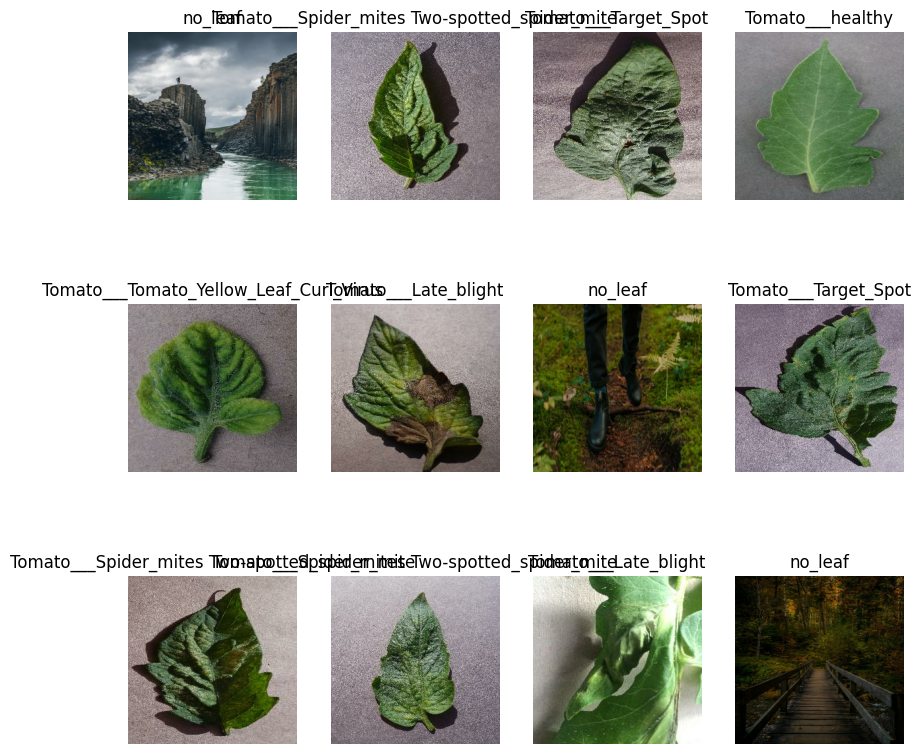

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model


In [11]:
len(dataset)

375

In [12]:
train_size = 0.8
trainDS=int(len(dataset)*train_size)

In [13]:
train_ds = dataset.take(trainDS) #taking the first trainDS elements
len(train_ds)

300

In [14]:
test_ds = dataset.skip(trainDS) #skipping the first trainDS elements
len(test_ds)

75

In [15]:
val_size=0.1
valDS=int(len(dataset)*val_size)

In [16]:
val_ds = test_ds.take(valDS)
len(val_ds)

37

In [17]:
test_ds = test_ds.skip(valDS)
len(test_ds)

38

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    assert (train_split + test_split + val_split) == 1
    # Get the total size of the dataset
    ds_size = len(ds)
    
    # Shuffle the dataset if shuffle is True
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    # Calculate sizes for training, validation, and test sets
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    # Partition the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)


300

In [21]:
len(val_ds)


37

In [22]:
len(test_ds)


38

## Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 12

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Add Dropout after the convolutional layers
    layers.Dropout(0.1),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (32, 62, 62, 64)         

## Compiling the Model

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/150


300/300 [==============================] - 1508s 4s/step - loss: 2.2383 - accuracy: 0.1991 - val_loss: 2.0197 - val_accuracy: 0.2905
Epoch 2/150
300/300 [==============================] - 1049s 3s/step - loss: 1.9278 - accuracy: 0.3195 - val_loss: 1.7974 - val_accuracy: 0.3843
Epoch 3/150
300/300 [==============================] - 1256s 4s/step - loss: 1.6368 - accuracy: 0.4397 - val_loss: 1.5398 - val_accuracy: 0.4755
Epoch 4/150
300/300 [==============================] - 1214s 4s/step - loss: 1.4143 - accuracy: 0.5206 - val_loss: 1.2907 - val_accuracy: 0.5811
Epoch 5/150
300/300 [==============================] - 1024s 3s/step - loss: 1.2682 - accuracy: 0.5803 - val_loss: 1.2997 - val_accuracy: 0.5693
Epoch 6/150
300/300 [==============================] - 1025s 3s/step - loss: 1.1361 - accuracy: 0.6143 - val_loss: 1.2489 - val_accuracy: 0.6030
Epoch 7/150
300/300 [==============================] - 998s 3s/step - loss: 1.0523 - accuracy: 0.6477 - val_loss: 1.1602 - val_accuracy: 0.627

In [31]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 170s 615ms/step - loss: 0.1955 - accuracy: 0.9342


In [32]:
history.params

{'verbose': 1, 'epochs': 150, 'steps': 300}

In [33]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.238297462463379,
 1.9278193712234497,
 1.6367744207382202,
 1.4143047332763672,
 1.268249273300171]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

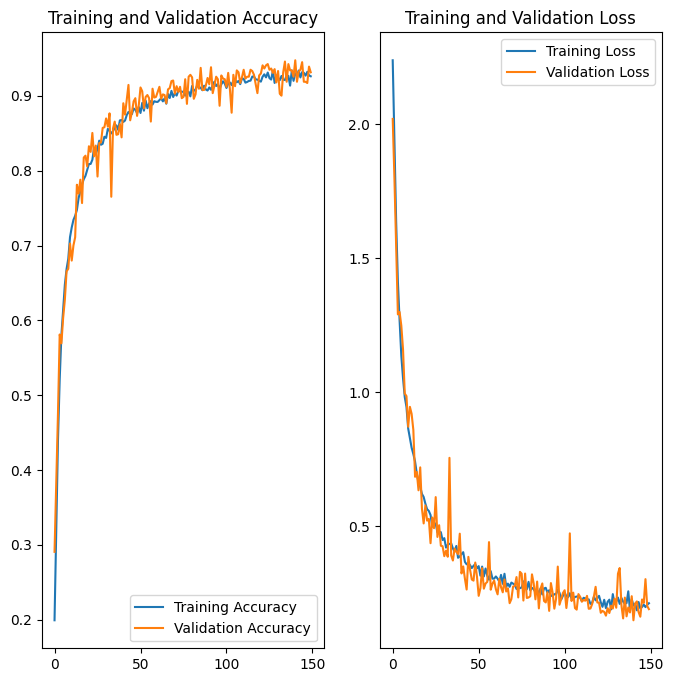

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato___Tomato_mosaic_virus
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___Tomato_mosaic_virus


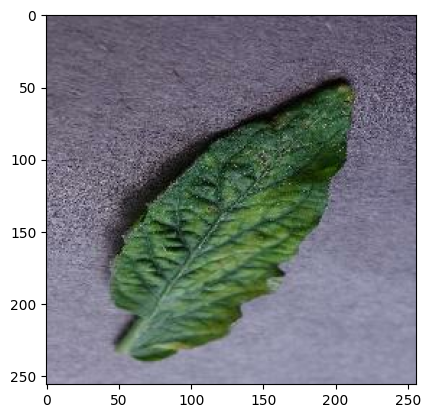

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

1/1 [==============================] - 0s 69ms/step


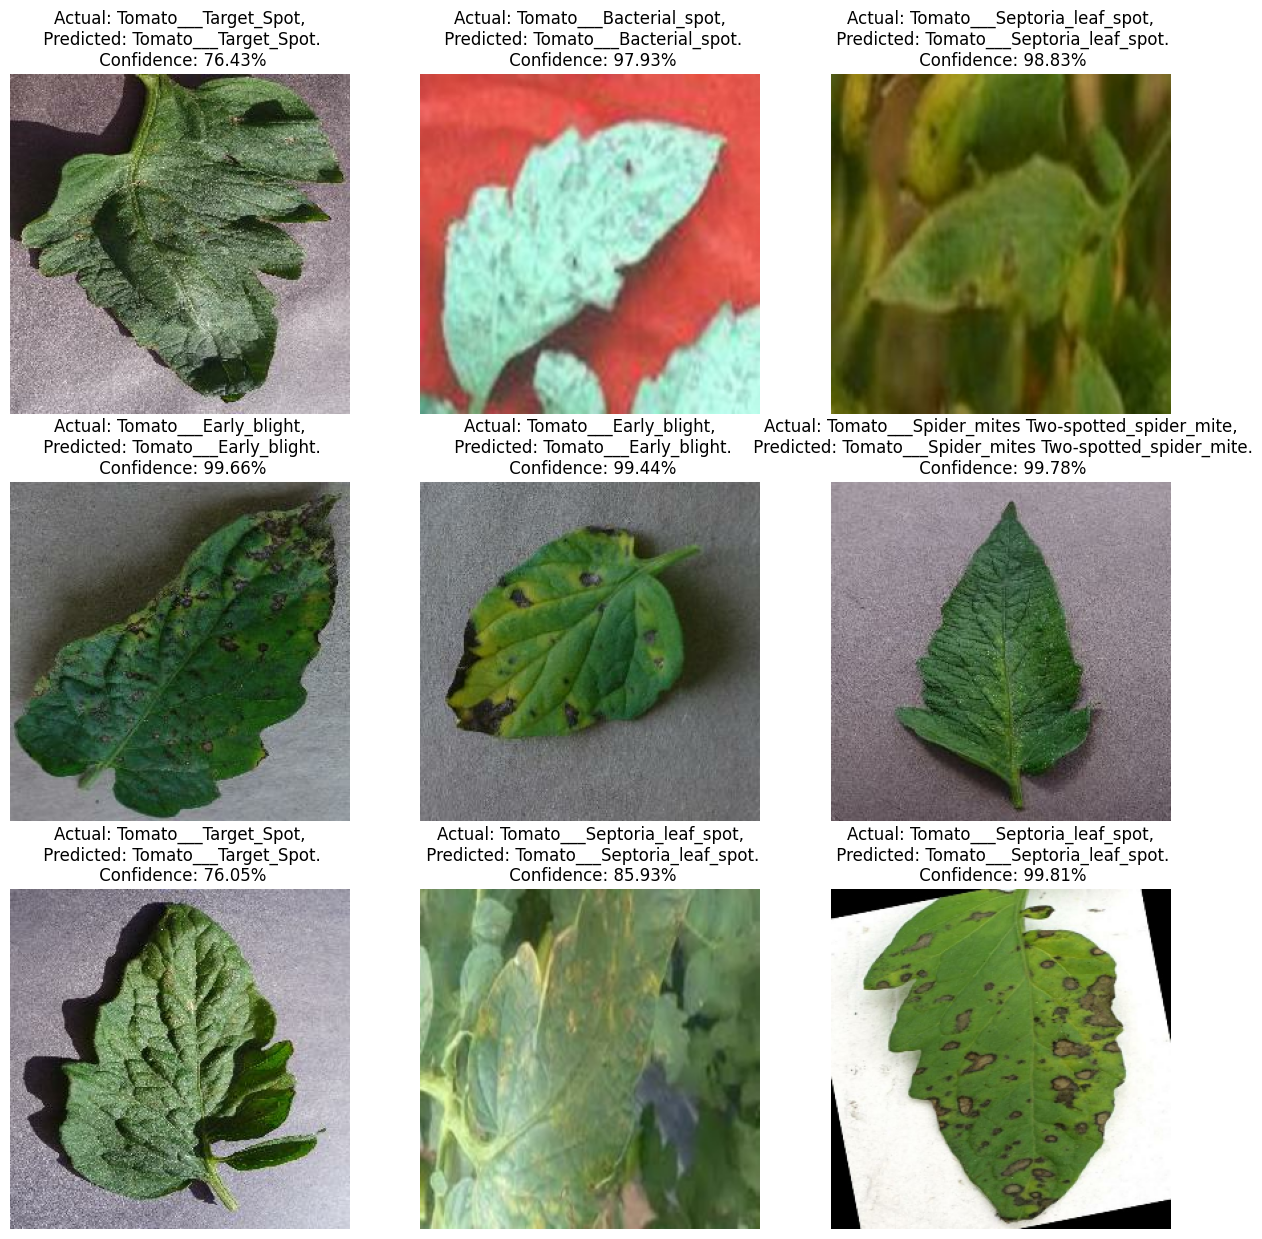

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [39]:
model.save("tomato12v3.h5")

C:\Users\fuyua\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## confusionMatrix

In [40]:
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get model predictions for the batch
    batch_predictions = model.predict(images_batch)
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(batch_predictions, axis=1)
    
    # Append true and predicted labels to the lists
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_classes)


1/1 [==============================] - 0s 448ms/step


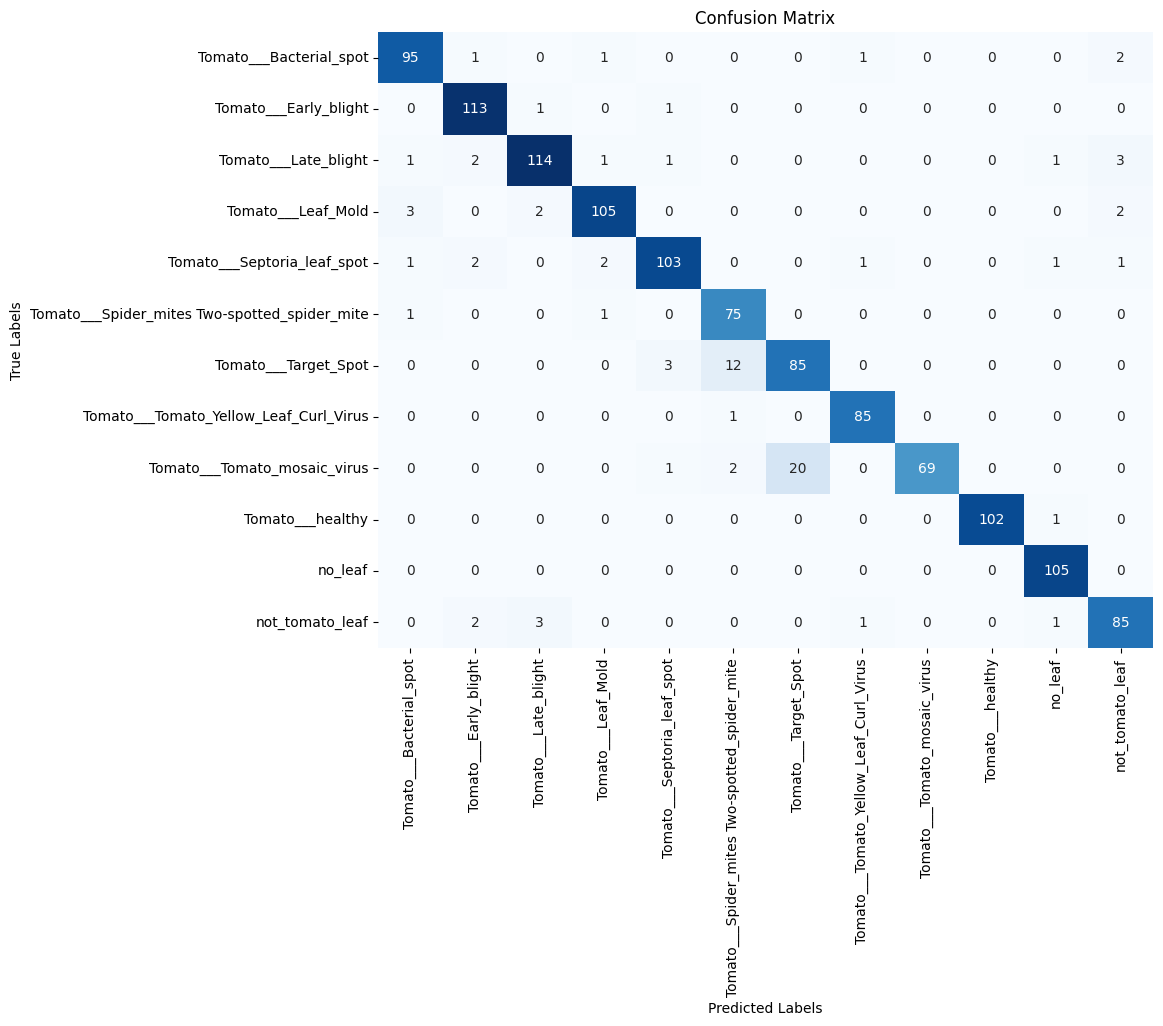

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a DataFrame for visualization
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## precision, recall, and F1-score

In [42]:
from sklearn.metrics import classification_report

test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)



In [43]:
# Predict on the test set
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Convert tensor to numpy array for classification report
true_labels = test_labels.numpy()
predicted_labels = predicted_labels.numpy()

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

38/38 [==============================] - 26s 693ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.95      0.95       100
                        Tomato___Early_blight       0.94      0.98      0.96       115
                         Tomato___Late_blight       0.95      0.93      0.94       123
                           Tomato___Leaf_Mold       0.95      0.94      0.95       112
                  Tomato___Septoria_leaf_spot       0.94      0.93      0.94       111
Tomato___Spider_mites Two-spotted_spider_mite       0.83      0.97      0.90        77
                         Tomato___Target_Spot       0.81      0.85      0.83       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98        86
                 Tomato___Tomato_mosaic_virus       1.00      0.75      0.86        92
                             Tomato___healthy       1.00      0.99      1